<a href="https://colab.research.google.com/github/guillermohenrion/AI/blob/master/semantic_word_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Estudio de los textos de Hayek realizando un LDA, asignando semántica a las componentes dentro del espacio semántico según una word embedding y viendo la posición de cada documento. Similarmente para bigramas.

##Instalar e importar paquetes

In [1]:
!pip install nltk==3.5
!pip install gensim==4.1.2
!pip install spacy==3.1.5
!pip install pyLDAvis==3.2.1
!python -m spacy download es_core_news_sm
!python -m spacy download fr_core_news_sm
# !pip install feedparser
# !pip install gspan


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.7 MB 4.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.1 MB 306 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [2]:
import nltk
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import random
import pandas as pd

import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
# from gensim.models.wrappers import LdaMallet, ldamallet
from gensim.corpora import Dictionary
import spacy

import csv
from unicodedata import normalize
import string
from wordcloud import WordCloud, STOPWORDS 
 
from sklearn.manifold import TSNE
#import gspan

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import es_core_news_sm
nlp = es_core_news_sm.load()

In [4]:
#!ls *.txt


#Leer documentos y procesar a txt

In [38]:
# '14_many_newlines_removed.txt'
# nombres_textos=['individualismo.txt','Hayek - A dónde va la democracia.txt','Hayek - Los principios de un orden social liberal.txt',
#               'Hayek - El uso del conocimiento en la sociedad.txt','Hayek - La fatal arrogancia. Los errores del socialismo.txt',
#              'Hayek - Camino de servidumbre.txt','Hayek - Precios y Producción.txt','Hayek - El mensaje de Adam Smith en el lenguaje actual.txt']

# nombres_textos=['Hayek - Individualismo.txt','Hayek - La fatal arrogancia. Los errores del socialismo.txt']

nombres_textos=[#'txts/Hayek - A donde va la democracia.txt',
              'txts/Hayek - Camino de servidumbre.txt',
              #'txts/Hayek - El mensaje de Adam Smith en el lenguaje actual.txt',
              #'txts/Hayek - El uso del conocimiento en la sociedad.txt',
              'txts/Hayek - Individualismo: El verdadero y el falso.txt',
              #'txts/Hayek - La fatal arrogancia. Los errores del socialismo.txt',
              #'txts/Hayek - Liberalismo.txt',
              #'txts/Hayek - Los Fundamentos de la Libertad.txt',
              #'txts/Hayek - Los principios de un orden social liberal.txt',
              #'txts/Hayek - Precios y Produccion.txt'
              ]
                
                #'txts/Hayek - A donde va la democracia.txt', #1944
                #'txts/Hayek - El mensaje de Adam Smith en el lenguaje actual.txt', #1976
                #'txts/Hayek - El uso del conocimiento en la sociedad.txt', #1945
                #'txts/Hayek - Individualismo.txt', # 1948
                #'txts/Hayek - Liberalismo.txt',  # 1973
                #'txts/Hayek - Los principios de un orden social liberal.txt', #1966
                #'txts/Hayek - Precios y Produccion.txt']  #1931

#'Hayek - Los Fundamentos de la Libertad.txt' da error en el preprocesamiento por superar 1M de caracteres

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# !cp -r "drive/MyDrive/Colab Notebooks/Historical Text Analytics/Hayek - Camino de servidumbre/" /content
!rsync -aP "drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/txts" /content

sending incremental file list
txts/
txts/Hayek - A donde va la democracia.txt
         28,565 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=123/125)
txts/Hayek - Camino de servidumbre.txt
        857,836 100%    1.04MB/s    0:00:00 (xfr#2, to-chk=122/125)
txts/Hayek - El mensaje de Adam Smith en el lenguaje actual.txt
          8,134 100%    0.00kB/s    0:00:00 (xfr#3, to-chk=121/125)
txts/Hayek - El uso del conocimiento en la sociedad.txt
         36,511 100%   53.86kB/s    0:00:00 (xfr#4, to-chk=120/125)
txts/Hayek - Individualismo: El verdadero y el falso.txt
         66,094 100%   46.60kB/s    0:00:01 (xfr#5, to-chk=119/125)
txts/Hayek - La fatal arrogancia. Los errores del socialismo.txt
        586,768 100%  836.52kB/s    0:00:00 (xfr#6, to-chk=118/125)
txts/Hayek - Liberalismo.txt
         90,434 100%   54.99MB/s    0:00:00 (xfr#7, to-chk=117/125)
txts/Hayek - Los Fundamentos de la Libertad.txt
      1,519,791 100%    1.91MB/s    0:00:00 (xfr#8, to-chk=116/125)
txts/Hayek - Los pri

In [40]:
import pandas as pd
doct=pd.DataFrame(columns=["Nombre", "Texto"])


In [41]:
doc=[]

for r in nombres_textos:
    with open(r,'r',encoding='utf-8') as f:
        print(r)
        doc1=f.read()
        if (r=='txts/Hayek - Camino de servidumbre.txt'):
          doc1=doc1[193803:639188]
        doc.append(doc1)
        df2 = {'Nombre': r, 'Texto': doc1}
        doct=doct.append(df2, ignore_index = True)


txts/Hayek - Camino de servidumbre.txt
txts/Hayek - Individualismo: El verdadero y el falso.txt


In [ ]:
#from os import listdir
#from os.path import isfile, join

#nombres_libros=['txts/Hayek - Camino de servidumbre',
#                'txts/Hayek - La fatal arrogancia. Los errores del socialismo',
#                'txts/Hayek - Los Fundamentos de la Libertad']

#for l in nombres_libros:
#    carpeta=l
    # carpeta_drive="drive/MyDrive/Colab Notebooks/"+carpeta
    # !cp -r carpeta_drive /content
#    nombres_capitulos = [f for f in listdir(carpeta) if isfile(join(carpeta, f))]
#    nombres_capitulos = [k for k in nombres_capitulos if 'txt' in k]
    
   #     print(l)
#    for r in nombres_capitulos:
#        with open(f'{l}/'+r,'r',encoding='utf-8') as f:
#            doc1=f.read()
#            doc.append(doc1)
#            df2 = {'Nombre': r, 'Texto': doc1}
#            doct=doct.append(df2, ignore_index = True)


In [ ]:
#doct.loc[doct['Nombre'] == "txts/Hayek - A donde va la democracia.txt"]


In [42]:
def preprocessing(text,stopwords):
    text = text.lower()  # texto a minúsculas
    text = re.sub(r'\[.*?¿\]%', ' ', text)  # Se remueven corchetes
    text = re.sub(r'\(.*?¿\)%', ' ', text)  # Se remueven parentesis
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # Se remueven signos de puntuación
    text = re.sub(r'\w*\d\w*', '', text)  # Se remueven palabras que contienen dígitos.
    text = re.sub(r'\n', ' ', text)  # Sustituye nueva línea por un espacio
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Sustituye los múltiples espacios por sólo un espacio
    text = re.sub(r'[‘’“”…«»°*_/¿¡!?]', '', text)  # Remueve otros caracteres no sintácticos
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+|\u20AC", r"\1",
                  normalize("NFD", text), 0, re.I)  # NFD y eliminar diacríticos y símbolo euro
    text = normalize('NFC', text)  # NFC
    bigram_list = bigram[text.split()]
    out_text = lemmatization(' '.join(bigram_list), allowed_postags=['NOUN'])  # ,'VERB','ADJ', 'PROPN'
    text_non_stop = [word for word in out_text if word not in stopwords]

    return text_non_stop

def lemmatization(texts, allowed_postags=None):
    if allowed_postags is None:
        allowed_postags = ['NOUN']
    texts_out = [token.lemma_ for token in nlp(texts) if token.pos_ in allowed_postags]
                 #allowed_postags and token.text not in black_list and len(token.text) > 2]
    return texts_out


def display_topics(model, model_type='lda'):
    for topic_idx, topic in enumerate(model.print_topics()):
        print('Topic %d:' % topic_idx)
        if model_type == 'hdp':
            print(" ".join(re.findall(r'\*(.[^\*-S]+).?', topic[1])), '\n')
        else:
            print(" ".join(re.findall(r'\"(.[^"]+).?', topic[1])), '\n')

def format_topics_sentences(ldamodel=0, corpus=[], texts=0):
    sent_topics_df = pd.DataFrame()  # - n

    # Tema principal en cada documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Tema dominante, porcentaje de contribución y palabras claves
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Tema dominante
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Agrega el texto original al final
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

#BOW

In [43]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,random_state=100)
        else:
          lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,random_state=100)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

In [44]:
stopwords = nltk.corpus.stopwords.words('spanish')
bigram = gensim.models.Phrases(doc, min_count=5, threshold=2.0)
stopwords.extend(['d', 'd', 'h', 'l','n', 'c', 'ta','s','p', 'r', 'vez','pagina','parte','ejemplo','medida','modo','tipo','forma','punto','hecho','parrafo','mas','hayek','lugar','embargo','caso','solo',
                 'fin','medio','año','inter'])

In [45]:
bow=[]
frecuenciaPalab_docs=[]

for i,d in enumerate(doc):
    # print(i)
    bow.append(preprocessing(d, stopwords))

    frecuenciaPalab = []
    for w in bow[i]:
        frecuenciaPalab.append(bow[i].count(w))

    frecuenciaPalab_docs.append(frecuenciaPalab)
    
# print("Lista\n" + str(bow[0]) + "\n")
# print("Frecuencias\n" + str(frecuenciaPalab_docs[0]) + "\n")
# print("Pares\n" + str(list(zip(bow[0], frecuenciaPalab_docs[0]))))

In [46]:
corpus_completo=[]
for d in bow:
    corpus_completo+=d

corpus_completo_palabras=set(corpus_completo)
len(corpus_completo_palabras)

3131

In [54]:
corpus_1=[]
corpus_2=[]

i=0
for d in bow:
    if i==0:
        corpus_1+=d
    if i==1:
        corpus_2+=d
    i=i+1

corpus_1_palabras=set(corpus_1)
print(len(corpus_1_palabras))
corpus_2_palabras=set(corpus_2)
len(corpus_2_palabras)

2912


732

In [55]:
frecuenciaPalab_completo = []
for w in corpus_completo_palabras:
    frecuenciaPalab_completo.append(corpus_completo.count(w))

In [56]:
#20 palabras más populares todo el corpus
frec_df=pd.DataFrame(list(zip(corpus_completo_palabras,frecuenciaPalab_completo)))
frec_df.columns=['palabra','frec']
frec_df.drop_duplicates(inplace=True)
frec_df.sort_values(by='frec',ascending=False,inplace=True)
frec_df.head(20)


,palabra,frec
2969,libertad,209
2742,sociedad,195
2901,poder,156
2802,hombre,147
1552,individuo,142
1783,socialismo,140
1166,sistema,133
1618,gente,121
2559,persona,117
1445,vida,115


In [ ]:
#corpus

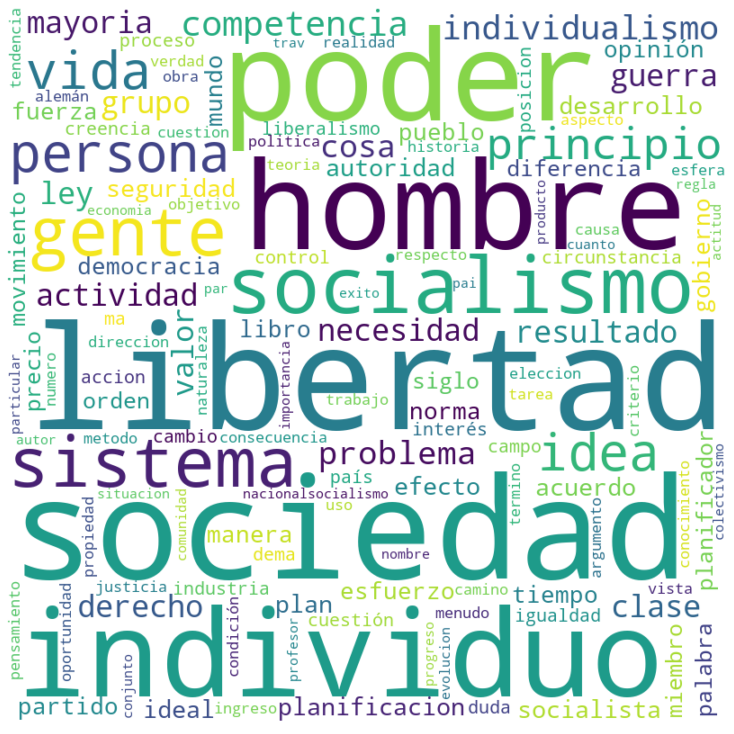

In [57]:
text = " ".join(corpus_completo)

wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords,
                min_font_size = 12,collocations = False).generate(text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [58]:
frec_df=pd.DataFrame(list(zip(bow[0], frecuenciaPalab_docs[0])))
frec_df.columns=['palabra','frec']
frec_df.drop_duplicates(inplace=True)
frec_df.sort_values(by='frec',ascending=False,inplace=True)
frec_df.head(20)

,palabra,frec
52,libertad,201
343,sociedad,155
646,poder,135
232,socialismo,129
130,sistema,120
1122,individuo,112
152,vida,111
196,gente,109
256,persona,107
2,idea,105


In [59]:
corpus_completo

['descubrimiento',
 'genealogia',
 'idea',
 'acontecimiento',
 'historia',
 'resultado',
 'atra',
 'significacion',
 'suceso',
 'consecuencia',
 'transito',
 'historia',
 'historia',
 'pais',
 'destello',
 'trav',
 'acontecimiento',
 'saber',
 'cuan',
 'cosa',
 'menudo',
 'cambio',
 'suerte',
 'hombre',
 'experiencia',
 'historia',
 'historia',
 'completo',
 'evolucion',
 'pasado',
 'repeticion',
 'proceso',
 'profeta',
 'peligro',
 'combinacion',
 'atencion',
 'experiencia',
 'menudo',
 'hombre',
 'acontecimiento',
 'aspecto',
 'producto',
 'experiencia',
 'trav',
 'periodo',
 'may',
 'democracy',
 'essays',
 'cit',
 'español',
 'democracia',
 'ensayo',
 'libertad',
 'editorial',
 'evolución',
 'idea',
 'experiencia',
 'pais',
 'circunstancia',
 'país',
 'influencia',
 'marcha',
 'pensamiento',
 'mayoria',
 'país',
 'velocidad',
 'pai',
 'evolucion',
 'fase',
 'opinión',
 'encontro',
 'significado',
 'signo',
 'rumbo',
 'necesidad',
 'probabilidad',
 'acontecimiento',
 'curso',
 'verd

#Display semantic space

In [ ]:
import gensim.corpora as corpora

# Create Dictionary
#Listado de palabras únicas
id2word = corpora.Dictionary(bow)

# Term Document Frequency
corpus = [id2word.doc2bow(t) for t in bow]

# View
print(corpus[:1][0][:30])

[(0, 4), (1, 2), (2, 1), (3, 2), (4, 2), (5, 1), (6, 7), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 7), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 3), (23, 5), (24, 34), (25, 8), (26, 1), (27, 3), (28, 1), (29, 1)]


In [ ]:
!cp "drive/MyDrive/Colab Notebooks/Historical Text Analytics/embbedings/SBW-vectors-300-min5.txt" /content


In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format("SBW-vectors-300-min5.txt", binary=False)

In [ ]:
data=model.most_similar(positive=['crédito', 'hombre']) 

In [ ]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords) 

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


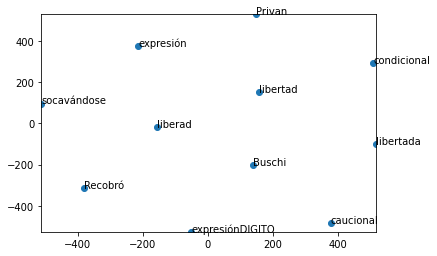

In [ ]:
display_closestwords_tsnescatterplot(model, "libertad")

#Análisis de n-grams

In [ ]:
def initialize_ngram_finder(list_of_tokens):
    """
    This function will initialize ngram finders for both bigrams & trigrams.
    
    arguments:
        input_text: "list_of_tokens" of type "list" containing all alphanum tokens for each article.
                    
    return:
        value: "bigrams", "trigrams", "bigramFinder", "trigramFinder"
        
    """
    # A number of standard association
    # measures are provided in BigramAssocMeasures and TrigramAssocMeasures.
    bigrams = nltk.collocations.BigramAssocMeasures()
    trigrams = nltk.collocations.TrigramAssocMeasures()
    
    # BigramCollocationFinder --> A tool for the finding and ranking of Bigram collocations or other
    # association measures. It is often useful to use from_words() rather than
    # constructing an instance directly.
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(list_of_tokens, window_size=3)
    # TrigramCollocationFinder --> A tool for the finding and ranking of trigram collocations or other
    # association measures. It is often useful to use from_words() rather than
    # constructing an instance directly.
    trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(list_of_tokens, window_size=3)
    return bigrams, trigrams, bigramFinder, trigramFinder


In [ ]:
# bigrams, trigrams, bigramFinder, trigramFinder = initialize_ngram_finder(bow[1])
bigrams, trigrams, bigramFinder, trigramFinder = initialize_ngram_finder(corpus_completo)

In [ ]:
def freq_counting_bigram(bigramFinder):
    """
    This function will count how many times adjacent words co-occurs as bigrams.
    
    arguments:
        input_text: "bigramFinder" of type "nltk.collocations.BigramCollocationFinder". 
                    
    return:
        value: "bigramFreqTable" of type "pandas Dataframe" 
                containing bigrams and their corresponding frequencies.
        
    """
    # Generate list of bigrams w.r.t their frequency.
    bigram_freq = bigramFinder.ngram_fd.items()
    # Create Dataframe having bigrams as one column & their corresponding frequency as other column 
    # sorted in descending order of frequency.
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
    freq_bi = bigramFreqTable[:100].bigram.values
    return bigramFreqTable, freq_bi


In [ ]:
bigramFreqTable, freq_bi = freq_counting_bigram(bigramFinder)
bigramFreqTable.head(10).reset_index(drop=True)


,bigram,freq
0,"(libertad, libertad)",18
1,"(sistema, competencia)",17
2,"(plan, plan)",13
3,"(seguridad, libertad)",12
4,"(poder, poder)",11
5,"(libertad, seguridad)",11
6,"(socialismo, socialismo)",10
7,"(competencia, competencia)",10
8,"(sociedad, competencia)",10
9,"(regimen, competencia)",9


In [ ]:
bigramFreqTable

,bigram,freq
3702,"(libertad, libertad)",18
2573,"(sistema, competencia)",17
5036,"(plan, plan)",13
13717,"(seguridad, libertad)",12
7271,"(poder, poder)",11
...,...,...
8829,"(procedimiento, estrategia)",1
8828,"(procedimiento, campaña)",1
8827,"(exito, campaña)",1
8826,"(exito, procedimiento)",1


In [ ]:
bigramFreqTable_dict=dict(zip(bigramFreqTable.bigram, bigramFreqTable.freq))
# bigramFreqTable_dict

In [ ]:
trigramFreqTable, freq_tri = freq_counting_bigram(trigramFinder)
trigramFreqTable.head(10).reset_index(drop=True)

,bigram,freq
0,"(sociedad, regimen, competencia)",8
1,"(cambio, significado, palabra)",4
2,"(siglo, xvii, xviii)",3
3,"(conferencia, paz, paris)",2
4,"(pode, consejo, administracion)",2
5,"(consejo, administracion, empresa)",2
6,"(argumento, favor, libertad)",2
7,"(competencia, competencia, importancia)",2
8,"(ideal, justicia, igualdad)",2
9,"(miembro, parlamento, miembro)",2


In [ ]:
# freq_bi=freq_bi.reshape(-1,1)
# freq_bi.shape

freq_bi=list(freq_bi)
freq_bi_comp=[]
freq_bi_comp.append(freq_bi)

In [ ]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import models

docs = ['new york is is united states', 'new york is most populated city in the world','i love to stay in new york']

token_ = [doc.split(" ") for doc in docs]
# bigram = Phrases(token_, min_count=1, threshold=2,delimiter=b' ')
# bigram = Phrases(bow, min_count=5, threshold=2,delimiter=b' ')

# bigram_phraser = Phraser(bigram)
# bigram_token = []
# for sent in token_:
#     bigram_token.append(bigram_phraser[sent])

phrases = Phrases(bow,min_count=2)
bigrams = Phraser(phrases)    
# bigrams

bigram_token = []
for sent in bow:
    bigram_token.append(bigrams[sent])

# for doc in bow:
#     bigrams_doc = list(ngrams(doc, 2)) 
#     bigram_token.append(bigrams_doc)

In [ ]:
corpus_completo_bigramas=[]
for d in bigram_token:
    corpus_completo_bigramas+=d

# corpus_completo_palabras=set(corpus_completo)
# len(corpus_completo_palabras)

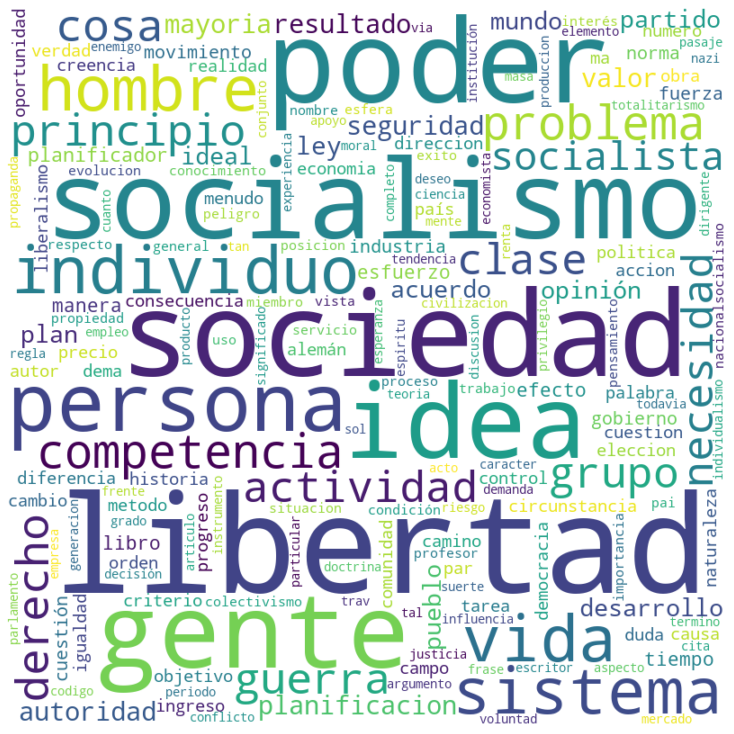

In [ ]:
#Todo incluyendo bigramas

text = " ".join(corpus_completo_bigramas)
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords,
                min_font_size = 12,collocations = False).generate(text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [ ]:
corpus_completo_bigramas2=list(filter(lambda k: '_' in k, corpus_completo_bigramas))
corpus_completo_bigramas2 = [ele for ele in corpus_completo_bigramas2 if not(ele in 'camino_servidumbre')]

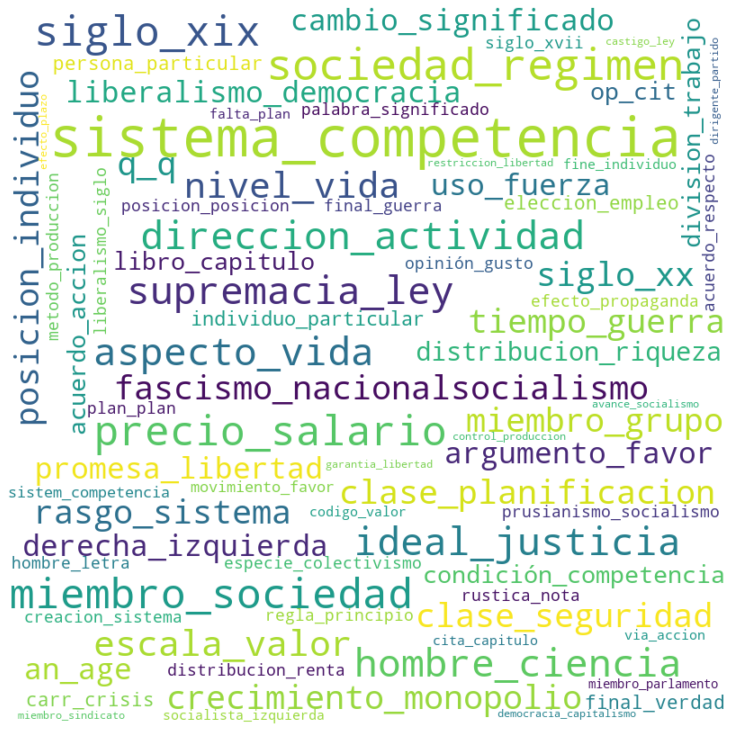

In [ ]:
#Solo bigramas
text = " ".join(corpus_completo_bigramas2)

wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords,
                min_font_size = 12,collocations = False).generate(text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [ ]:
# id2word = corpora.Dictionary(bow)

# # Term Document Frequency
# corpus = [id2word.doc2bow(t) for t in bow]


import gensim.corpora as corpora

#Listado de bigramas únicos
id2word_bi = corpora.Dictionary(bigram_token)

# Term Document Frequency
corpus_bi = [id2word_bi.doc2bow(t) for t in bigram_token]

# View
print(corpus_bi[:1][0][:30])


[(0, 4), (1, 2), (2, 1), (3, 2), (4, 2), (5, 1), (6, 7), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 7), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 3), (23, 5), (24, 27), (25, 8), (26, 1), (27, 3), (28, 1), (29, 1)]


In [ ]:
import gensim.corpora as corpora

# Create Dictionary
#Listado de palabras únicas
id2word = corpora.Dictionary(bow)

# Term Document Frequency
corpus = [id2word.doc2bow(t) for t in bow]

# View
print(corpus[:1][0][:30])

[(0, 4), (1, 2), (2, 1), (3, 2), (4, 2), (5, 1), (6, 7), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 7), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 3), (23, 5), (24, 34), (25, 8), (26, 1), (27, 3), (28, 1), (29, 1)]


#LDA

In [ ]:
%%time

from pprint import pprint

# number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       iterations=100,
                                       random_state=100)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"libertad" + 0.008*"sociedad" + 0.007*"individuo" + 0.007*"poder" + '
  '0.006*"sistema" + 0.006*"gente" + 0.006*"socialismo" + 0.006*"persona" + '
  '0.006*"idea" + 0.006*"competencia"'),
 (1,
  '0.011*"libertad" + 0.010*"sociedad" + 0.007*"poder" + 0.007*"individuo" + '
  '0.007*"socialismo" + 0.007*"sistema" + 0.007*"idea" + 0.006*"persona" + '
  '0.006*"vida" + 0.006*"gente"'),
 (2,
  '0.013*"libertad" + 0.010*"sociedad" + 0.009*"poder" + 0.009*"socialismo" + '
  '0.008*"vida" + 0.008*"sistema" + 0.007*"gente" + 0.007*"competencia" + '
  '0.007*"hombre" + 0.007*"persona"')]
CPU times: user 61.7 ms, sys: 62.1 ms, total: 124 ms
Wall time: 187 ms


In [ ]:
import gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim
# import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#     LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    # with open(LDAvis_data_filepath, 'wb') as f:
    #     pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, 'results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
2     -0.003108  0.0       1        1  99.994244
1      0.000453 -0.0       2        1   0.002915
0      0.002656  0.0       3        1   0.002841, topic_info=            Term        Freq       Total Category  logprob  loglift
1642    libertad  182.000000  182.000000  Default  30.0000  30.0000
2583    sociedad  137.000000  137.000000  Default  29.0000  29.0000
2112       poder  127.000000  127.000000  Default  28.0000  28.0000
2579  socialismo  122.000000  122.000000  Default  27.0000  27.0000
2567     sistema  104.000000  104.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2866        vida    0.001946  108.866731   Topic3  -5.3136  -0.4634
1316       grupo    0.001322   56.675780   Topic3  -5.6998  -0.1968
2204    problema    0.001495   74.403281   Topic3  -5.5772  -0.3464
2194   principio    0.001406   67.639142   Topic3  -5.6388  -0.3127
2513   seguridad    0.001313   60.248602   Topic3  -5.7072  -0.2653

[250 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
35        1  0.977502       actitud
36        1  1.002417     actividad
47        1  1.005522       acuerdo
113       1  0.749717  alimentacion
123       1  0.748624        altura
...     ...       ...           ...
2820      1  0.780746    valoración
2844      1  1.008249        verdad
2864      1  0.747131    victoriano
2866      1  1.001224          vida
2879      1  0.752061    visionario

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

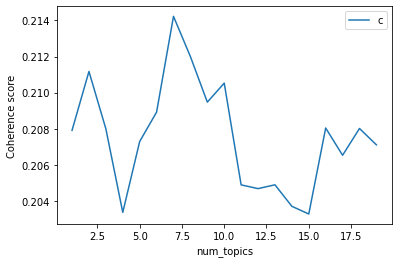

([<gensim.models.ldamodel.LdaModel at 0x7f0e6471f550>,
 [0.207915763062906,
  0.21117357557042077,
  0.20800027769666155,
  0.2033737595835206,
  0.20729625436316237,
  0.20892384540233036,
  0.2142264307679176,
  0.2119990235625434,
  0.20947718255539563,
  0.21052760047805688,
  0.20489582765772035,
  0.20468876579308626,
  0.20490001476534786,
  0.20371004005896393,
  0.20328322230891696,
  0.20804375801287944,
  0.2065354711613939,
  0.20801797390186313,
  0.20711200361389032])

In [ ]:
evaluate_graph(id2word,corpus,bow,20,'lda')

In [ ]:
lda_model.show_topics()


[(0,
  '0.011*"libertad" + 0.008*"sociedad" + 0.007*"individuo" + 0.007*"poder" + 0.006*"sistema" + 0.006*"gente" + 0.006*"socialismo" + 0.006*"persona" + 0.006*"idea" + 0.006*"competencia"'),
 (1,
  '0.011*"libertad" + 0.010*"sociedad" + 0.007*"poder" + 0.007*"individuo" + 0.007*"socialismo" + 0.007*"sistema" + 0.007*"idea" + 0.006*"persona" + 0.006*"vida" + 0.006*"gente"'),
 (2,
  '0.013*"libertad" + 0.010*"sociedad" + 0.009*"poder" + 0.009*"socialismo" + 0.008*"vida" + 0.008*"sistema" + 0.007*"gente" + 0.007*"competencia" + 0.007*"hombre" + 0.007*"persona"')]

#LDA con bigramas


In [ ]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model_bi = gensim.models.LdaMulticore(corpus=corpus_bi,
                                       id2word=id2word_bi,
                                       num_topics=num_topics,
                                       iterations=100,
                                       random_state=100)

# Print the Keyword in the 10 topics
pprint(lda_model_bi.print_topics())
doc_lda_bi = lda_model_bi[corpus]
lda_model_bi[corpus[0]]

[(0,
  '0.009*"libertad" + 0.007*"sociedad" + 0.006*"socialismo" + 0.006*"idea" + '
  '0.005*"individuo" + 0.005*"vida" + 0.005*"gente" + 0.005*"persona" + '
  '0.005*"poder" + 0.005*"hombre"'),
 (1,
  '0.009*"libertad" + 0.008*"socialismo" + 0.008*"poder" + 0.007*"individuo" + '
  '0.007*"sociedad" + 0.007*"idea" + 0.007*"gente" + 0.007*"persona" + '
  '0.006*"sistema" + 0.006*"hombre"'),
 (2,
  '0.008*"sociedad" + 0.007*"libertad" + 0.007*"persona" + 0.007*"poder" + '
  '0.006*"gente" + 0.006*"socialismo" + 0.005*"vida" + 0.005*"hombre" + '
  '0.005*"competencia" + 0.005*"idea"'),
 (3,
  '0.015*"libertad" + 0.010*"poder" + 0.009*"sociedad" + 0.008*"gente" + '
  '0.007*"vida" + 0.007*"hombre" + 0.007*"individuo" + 0.006*"sistema" + '
  '0.006*"socialismo" + 0.006*"persona"'),
 (4,
  '0.008*"libertad" + 0.007*"sociedad" + 0.007*"socialismo" + 0.006*"persona" '
  '+ 0.006*"idea" + 0.006*"poder" + 0.006*"gente" + 0.005*"hombre" + '
  '0.004*"sistema" + 0.004*"competencia"'),
 (5,
  '0.01

[(3, 0.9999348)]

In [ ]:
import gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim
# import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared_bi = pyLDAvis.gensim.prepare(lda_model_bi, corpus_bi, id2word_bi)
#     LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    # with open(LDAvis_data_filepath, 'wb') as f:
    #     pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, 'results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared_bi

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.007294 -0.001122       1        1  99.993356
6     -0.004549  0.002036       2        1   0.000738
5     -0.002687 -0.000525       3        1   0.000738
9     -0.002146  0.000868       4        1   0.000738
8     -0.000907 -0.001588       5        1   0.000738
1     -0.000460  0.000383       6        1   0.000738
2      0.003540  0.000542       7        1   0.000738
7      0.003539 -0.000772       8        1   0.000738
0      0.005304 -0.000236       9        1   0.000738
4      0.005661  0.000412      10        1   0.000738, topic_info=           Term        Freq       Total Category  logprob  loglift
1684   libertad  205.000000  205.000000  Default  30.0000  30.0000
2168      poder  140.000000  140.000000  Default  29.0000  29.0000
2657   sociedad  124.000000  124.000000  Default  28.0000  28.0000
1328      gente  102.000000  102.000000  Default  27.0000  27.0000
2945       vida   99.000000   99.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2253  principio    0.000333   68.431171  Topic10  -5.7079  -0.4180
1501  individuo    0.000375   92.659180  Topic10  -5.5887  -0.6018
36    actividad    0.000330   68.518814  Topic10  -5.7171  -0.4285
459       clase    0.000307   65.520516  Topic10  -5.7895  -0.4561
784     derecho    0.000281   71.452953  Topic10  -5.8772  -0.6305

[809 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
20        1  0.869837      accesorio
24        1  0.992749         accion
32        1  0.878189  acompañamient
36        1  1.007023      actividad
37        1  0.904734     actividade
...     ...       ...            ...
2932      1  1.027739            via
2939      1  0.873632      vicisitud
2945      1  0.997863           vida
2971      1  0.839131         vuelta
2972      1  0.866689              w

[292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 6, 10, 9, 2, 3, 8, 1, 5])

#Tópicos dentro el espacio semántico

In [ ]:
import numpy as np
from gensim.test.utils import datapath
from gensim import utils

l = np.array([0.017*model.get_vector("libertad"), 0.009*model.get_vector("precio"), 0.008*model.get_vector("poder"),0.007*model.get_vector("bien"),0.007*model.get_vector("hombre"), 0.006*model.get_vector("produccion"), 0.006*model.get_vector("ley")])


In [ ]:
from numpy import *
def randCent(dataSet, k, s):
    n = shape(dataSet)[1]
    centroids = mat(zeros(n))
    for j in range(n):
        centroids[:,j] = np.sum(dataSet[:,j])
    return centroids/s

In [ ]:
s=0.017+0.009+0.008+0.007+0.007+0.006+0.006
centroid=randCent(l,1, s)
centroid=centroid.getA1()

In [ ]:
model.similar_by_vector(centroid)

[('libertad', 0.7767316102981567),
 ('creérsele', 0.7446049451828003),
 ('socavándose', 0.7387365102767944),
 ('lucharlas', 0.735815167427063),
 ('monopolizarla', 0.7315989136695862),
 ('coartara', 0.7308528423309326),
 ('restituirnos', 0.7286457419395447),
 ('encausarla', 0.7283784747123718),
 ('desposeidos', 0.7270509600639343),
 ('Averiguan', 0.7263656258583069)]

In [ ]:
s=0.011+0.009+0.008+0.007+0.006+0.006+0.006
l = np.array([0.011*model.get_vector("ley"), 0.009*model.get_vector("libertad"), 0.008*model.get_vector("poder"),0.007*model.get_vector("principio"),0.006*model.get_vector("individuo"), 0.006*model.get_vector("sociedad"), 0.006*model.get_vector("proceso")])
centroid=randCent(l,1, s)
centroid=centroid.getA1()

In [ ]:
model.similar_by_vector(centroid)

[('coartara', 0.7556817531585693),
 ('separársele', 0.744306206703186),
 ('socavándose', 0.7419633269309998),
 ('portaliano', 0.7410425543785095),
 ('Guzmancista', 0.7404754161834717),
 ('Sustentados', 0.7395446300506592),
 ('comprobársele', 0.7392594218254089),
 ('narcotización', 0.7388145327568054),
 ('principismo', 0.7371867895126343),
 ('podérsele', 0.7356439232826233)]

#Documentos en espacio LDA y espacio semántico

In [ ]:
#lda_model[corpus[20]]

In [ ]:
lda_model_app=[]
for d in corpus:
  lda_model_app.append(lda_model[d])

pd.DataFrame(lda_model_app)

,0
0,"(2, 0.9999424)"


#Collocation


In [60]:
type(corpus_completo)
import pickle

In [61]:
import pickle
import uuid
class SocialDocument:

    text    = ""
    corpus    = []

    def __init__(self, text, corpus):
        self.text    = text
        self.corpus  = corpus

    def identify(self):
        print("Text: %s"%(self.text))
        print("Corpus: %s"%(self.corpus))


In [81]:
sd0=SocialDocument(doc[0],corpus_1)
sd1=SocialDocument(doc[1],corpus_2)
sd=SocialDocument(doc,corpus_completo)

In [82]:
with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd0.pkl', 'wb') as outp:
    pickle.dump(sd0, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd1.pkl', 'wb') as outp:
    pickle.dump(sd1, outp, pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd.pkl', 'wb') as outp:
    pickle.dump(sd, outp, pickle.HIGHEST_PROTOCOL)

In [83]:
with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd1.pkl', 'rb') as inpt:
    sd1=pickle.load(inpt)
with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd0.pkl', 'rb') as inpt:
    sd0=pickle.load(inpt)
with open('drive/MyDrive/Colab Notebooks/Historical Text Analytics/Corpus/sd.pkl', 'rb') as inpt:
    sd=pickle.load(inpt)

In [86]:
sd.corpus

['descubrimiento',
 'genealogia',
 'idea',
 'acontecimiento',
 'historia',
 'resultado',
 'atra',
 'significacion',
 'suceso',
 'consecuencia',
 'transito',
 'historia',
 'historia',
 'pais',
 'destello',
 'trav',
 'acontecimiento',
 'saber',
 'cuan',
 'cosa',
 'menudo',
 'cambio',
 'suerte',
 'hombre',
 'experiencia',
 'historia',
 'historia',
 'completo',
 'evolucion',
 'pasado',
 'repeticion',
 'proceso',
 'profeta',
 'peligro',
 'combinacion',
 'atencion',
 'experiencia',
 'menudo',
 'hombre',
 'acontecimiento',
 'aspecto',
 'producto',
 'experiencia',
 'trav',
 'periodo',
 'may',
 'democracy',
 'essays',
 'cit',
 'español',
 'democracia',
 'ensayo',
 'libertad',
 'editorial',
 'evolución',
 'idea',
 'experiencia',
 'pais',
 'circunstancia',
 'país',
 'influencia',
 'marcha',
 'pensamiento',
 'mayoria',
 'país',
 'velocidad',
 'pai',
 'evolucion',
 'fase',
 'opinión',
 'encontro',
 'significado',
 'signo',
 'rumbo',
 'necesidad',
 'probabilidad',
 'acontecimiento',
 'curso',
 'verd

In [91]:
from nltk import FreqDist

# use to find bigrams, which are pairs of words
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, ngrams
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

bigram_collocation = BigramCollocationFinder.from_words(sd.corpus, 4)
print(bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 4))

print(bigram_collocation.ngram_fd[('sistema', 'competencia')])
print(bigram_collocation.ngram_fd[('sistema', 'competencia')])



[('siglo', 'xix'), ('siglo', 'xviii'), ('plan', 'plan'), ('precio', 'salario')]
22
22


In [ ]:


trigram_collocation_1 = TrigramCollocationFinder.from_words(corpus_completo, 4)
print(trigram_collocation_1.nbest(TrigramAssocMeasures.likelihood_ratio, 4))

#trigram_collocation_2 = TrigramCollocationFinder.from_words(corpus_2, 4)
#print(trigram_collocation_2.nbest(TrigramAssocMeasures.likelihood_ratio, 4))


print(trigram_collocation_1.ngram_fd[('sociedad', 'regimen', 'competencia')])
print(trigram_collocation_1.ngram_fd[('discusión', 'siglo', 'xix')])


[('plan', 'plan', 'plan'), ('sociedad', 'regimen', 'competencia'), ('discusión', 'siglo', 'xix'), ('pensador', 'siglo', 'xix')]
8
2
